In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
fraud_df = pd.read_csv('synthetic_fraud_dataset.csv')
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

[Text(0.5, 0, 'Fraud Label (0: Not Fraud, 1: Fraud)'),
 Text(0, 0.5, 'Fraud Count'),
 Text(0.5, 1.0, 'Fraud Claims')]

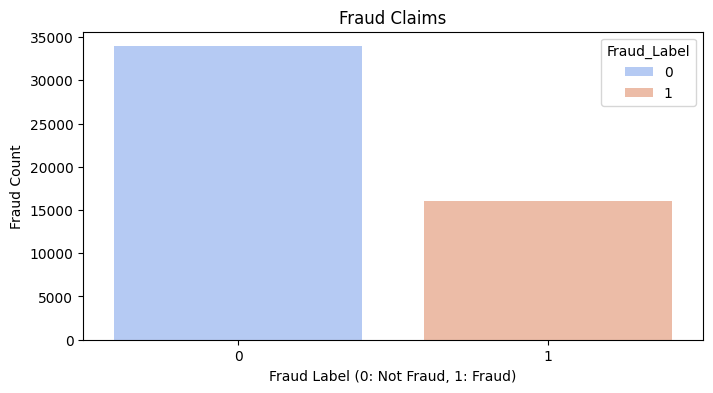

In [3]:
plt.figure(figsize=(8,4))
fraud_count = sns.countplot(fraud_df, x='Fraud_Label', palette='coolwarm', hue='Fraud_Label')
fraud_count.set(xlabel="Fraud Label (0: Not Fraud, 1: Fraud)", ylabel="Fraud Count", title="Fraud Claims")

[Text(0.5, 0, 'Device Type'),
 Text(0, 0.5, 'Fraud Count'),
 Text(0.5, 1.0, 'Fraud Claims per Device')]

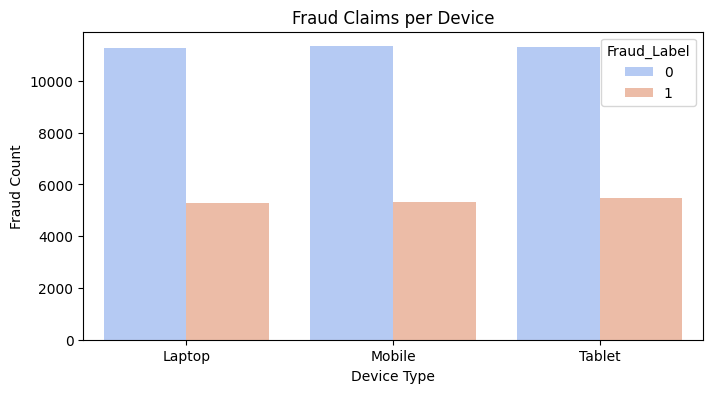

In [4]:
plt.figure(figsize=(8,4))
device_fraud = sns.countplot(fraud_df, x='Device_Type', palette='coolwarm', hue='Fraud_Label')
device_fraud.set(xlabel="Device Type", ylabel="Fraud Count", title="Fraud Claims per Device")

[Text(0.5, 0, 'Authentication Method'),
 Text(0, 0.5, 'Fraud Count'),
 Text(0.5, 1.0, 'Fraud Claims per Auth Method')]

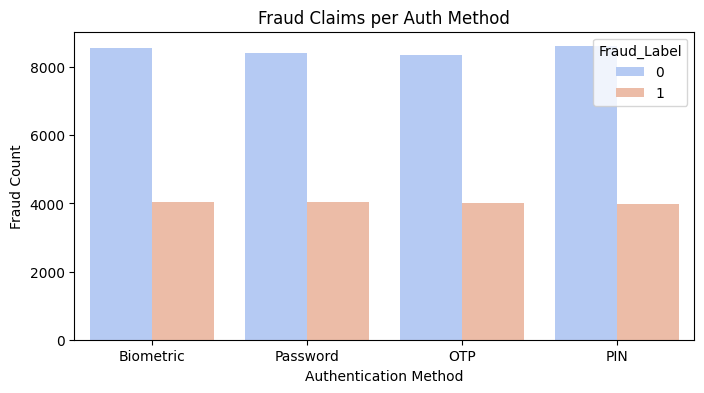

In [5]:
plt.figure(figsize=(8,4))
auth_fraud = sns.countplot(fraud_df, x='Authentication_Method', palette='coolwarm', hue='Fraud_Label')
auth_fraud.set(xlabel="Authentication Method", ylabel="Fraud Count", title="Fraud Claims per Auth Method")

In [6]:
def percentage_account(transaction, account_total):
    percentage = transaction/account_total
    return percentage*100

fraud_df["Transaction_Percentage"] = fraud_df.apply(lambda x: percentage_account(x["Transaction_Amount"], x["Account_Balance"]), axis = 1)

[Text(0.5, 0, 'Percentage of Acct Balance of Transaction'),
 Text(0, 0.5, 'Fraud'),
 Text(0.5, 1.0, 'Fraud Claims vs. % of acct Balance ')]

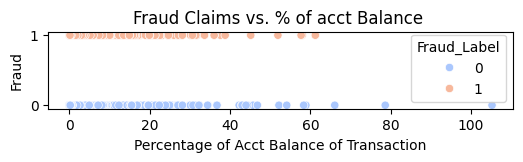

In [7]:
plt.figure(figsize=(6,1))
transactionP_fraud = sns.scatterplot(fraud_df, x='Transaction_Percentage', y='Fraud_Label', palette='coolwarm', hue='Fraud_Label')
transactionP_fraud.set(xlabel="Percentage of Acct Balance of Transaction", ylabel="Fraud", title="Fraud Claims vs. % of acct Balance ")

[Text(0.5, 0, 'Fraud Count'),
 Text(0, 0.5, 'Location'),
 Text(0.5, 1.0, 'Fraud Claims per Location')]

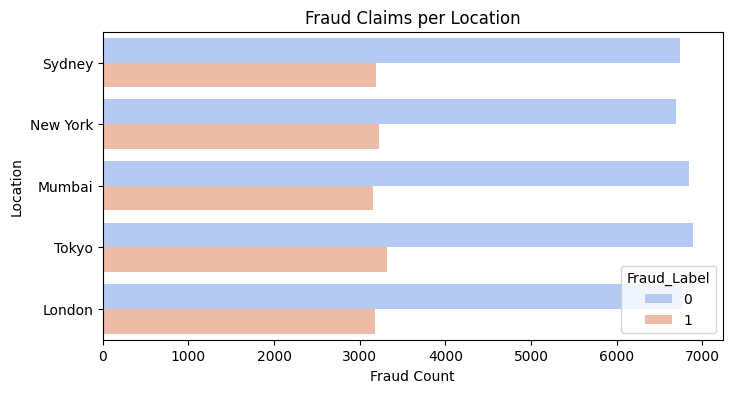

In [61]:
plt.figure(figsize=(8,4))
location_fraud = sns.countplot(fraud_df, y='Location', palette='coolwarm', hue='Fraud_Label')
location_fraud.set(xlabel="Fraud Count", ylabel="Location", title="Fraud Claims per Location")

<Figure size 600x100 with 0 Axes>

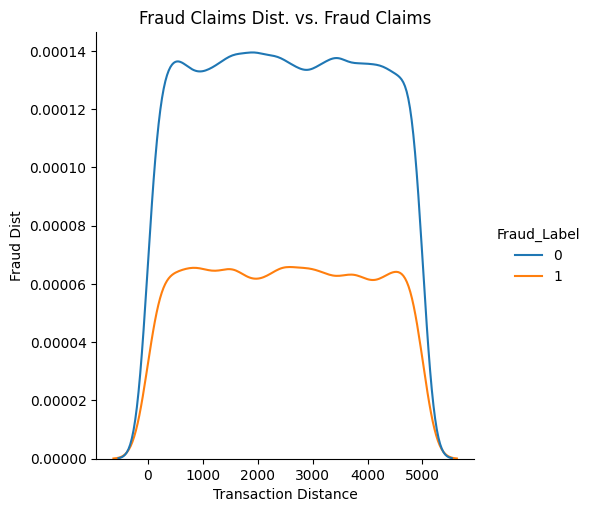

In [15]:
plt.figure(figsize=(6,1))
distance_fraud = sns.displot(fraud_df, x='Transaction_Distance', hue='Fraud_Label', kind="kde")
distance_fraud.set(xlabel="Transaction Distance", ylabel="Fraud Dist", title="Fraud Claims Dist. vs. Fraud Claims")

In [53]:
def ymd_hms(row):
    col = row["Timestamp"].split()

    ymd_format = col[0].split('-')
    hms_format = col[1].split(':')

    year, month, date = int(ymd_format[0]), int(ymd_format[1]), int(ymd_format[2])
    hour, minute, second = int(hms_format[0]), int(hms_format[1]), int(hms_format[2])

    row['Year'] = year
    row['Month'] = month
    row['Date'] = date
    row['Hour'] = hour
    row['Minute'] = minute
    row['Second'] = second

    return row

In [54]:
fraud_df_temp = fraud_df
fraud_df_temp = fraud_df_temp.apply(lambda x: ymd_hms(x), axis=1)
fraud_df_temp

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label,Year,Month,Date,Hour,Minute,Second
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,Biometric,0.8494,0,0,2023,8,14,19,30,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,Password,0.0959,0,1,2023,6,7,4,1,0
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,Biometric,0.8400,0,1,2023,6,20,15,25,0
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,OTP,0.7935,0,1,2023,12,7,0,31,0
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,Password,0.3819,1,1,2023,11,11,23,44,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,TXN_11284,USER_4796,45.05,Online,2023-01-29 18:38:00,76960.11,Mobile,Tokyo,Clothing,0,...,PIN,0.1493,1,0,2023,1,29,18,38,0
49996,TXN_44732,USER_1171,126.15,POS,2023-05-09 08:55:00,28791.75,Mobile,Tokyo,Clothing,0,...,Biometric,0.3653,0,1,2023,5,9,8,55,0
49997,TXN_38158,USER_2510,72.02,Online,2023-01-30 19:32:00,29916.41,Laptop,Mumbai,Clothing,0,...,Biometric,0.5195,0,0,2023,1,30,19,32,0
49998,TXN_860,USER_2248,64.89,Bank Transfer,2023-03-09 19:47:00,67895.67,Mobile,Tokyo,Electronics,0,...,Biometric,0.7063,0,1,2023,3,9,19,47,0


[Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Fraud Count'),
 Text(0.5, 1.0, 'Fraud Claims per Month')]

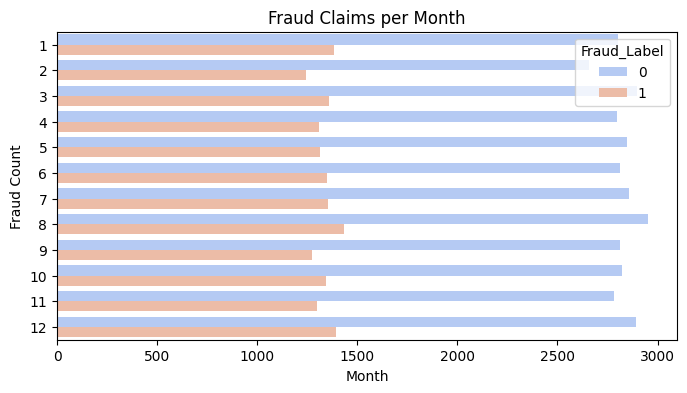

In [60]:
plt.figure(figsize=(8,4))
month_fraud = sns.countplot(fraud_df_temp, y='Month', palette='coolwarm', hue='Fraud_Label')
month_fraud.set(xlabel="Month", ylabel="Fraud Count", title="Fraud Claims per Month")

<Figure size 600x100 with 0 Axes>

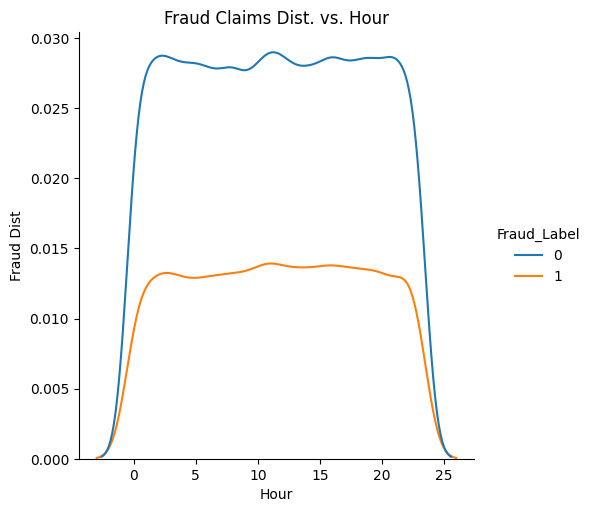

In [65]:
plt.figure(figsize=(6,1))
hour_fraud = sns.displot(fraud_df_temp, x='Hour', hue='Fraud_Label', kind="kde")
hour_fraud.set(xlabel="Hour", ylabel="Fraud Dist", title="Fraud Claims Dist. vs. Hour")

<Figure size 600x100 with 0 Axes>

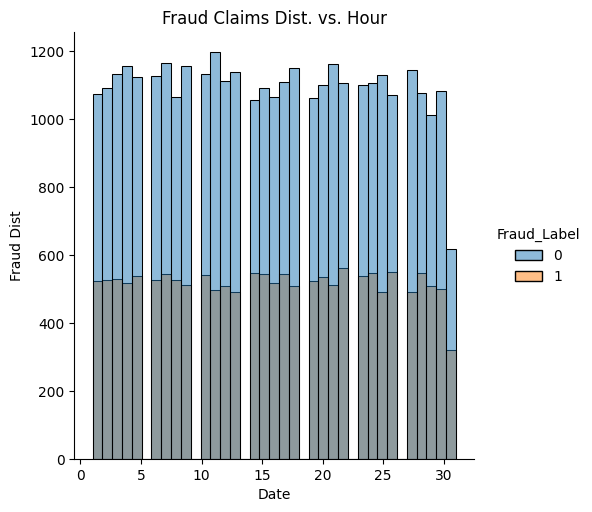

In [ ]:
from xgboost import XGBClassifier
# read data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(, data['target'], test_size=.2)

In [ ]:
fraud_df["Timestamp"][30]

0        2023-08-14 19:30:00
1        2023-06-07 04:01:00
2        2023-06-20 15:25:00
3        2023-12-07 00:31:00
4        2023-11-11 23:44:00
                ...         
49995    2023-01-29 18:38:00
49996    2023-05-09 08:55:00
49997    2023-01-30 19:32:00
49998    2023-03-09 19:47:00
49999    2023-08-19 23:57:00
Name: Timestamp, Length: 50000, dtype: object